In [7]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [8]:
tf.__version__

'2.18.0'

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import os
os.chdir(r"/content/drive/MyDrive/Colab Notebooks/Datasets/landslide_segmentation_dataset")
import cv2

## Testing the dataset

In [11]:
path_single = r"TrainData/img/image_100.h5"
path_single_mask = r"TrainData/mask/mask_100.h5"

ls ['img']
input data shape: (128, 128, 14)
data ndvi shape: (128, 128), f_data shape: (1, 128, 128, 3)


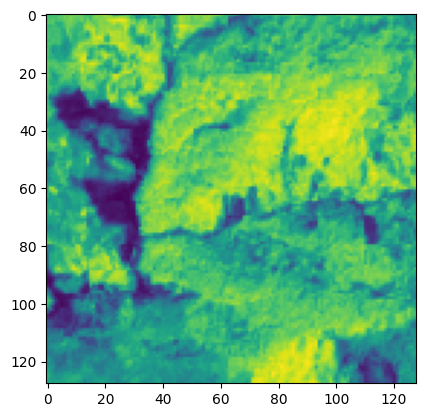

In [12]:
f_data = np.zeros((1, 128, 128, 3))
with h5py.File(path_single) as hdf:
  ls = list(hdf.keys())
  print("ls", ls)
  data = np.array(hdf.get('img'))
  print("input data shape:", data.shape)
  plt.imshow(data[:, :, [3, 2, 1]])

  data_red = data[:, :, 3]
  data_green = data[:, :, 2]
  data_blue = data[:, :, 1]
  data_nir = data[:, :, 7]
  data_rgb = data[:, :, [3, 2, 1]]
  data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red))
  f_data[0, :, :, 0] = data_ndvi
  f_data[0, :, :, 1] = data[:, :, 12]
  f_data[0, :, :, 2] = data[:, :, 13]

  print(f"data ndvi shape: {data_ndvi.shape}, f_data shape: {f_data.shape}")
  plt.imshow(data_ndvi)

ls ['mask']
input data shape: (128, 128)


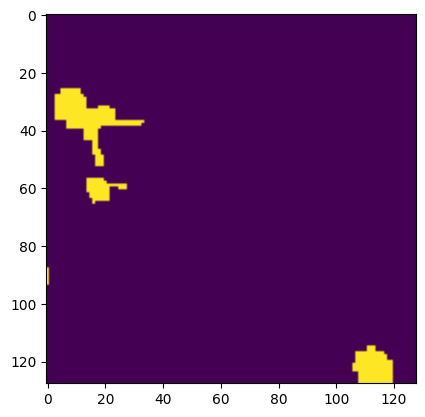

In [13]:
f_data = np.zeros((1, 128, 128, 3))
with h5py.File(path_single_mask) as hdf:
  ls = list(hdf.keys())
  print("ls", ls)
  data = np.array(hdf.get('mask'))
  print("input data shape:", data.shape)
  plt.imshow(data)

## Using all dataset

In [14]:
train_path = r"TrainData/img/*.h5"
train_mask = r"TrainData/mask/*.h5"

train_xx = np.zeros((50, 128, 128, 6))
train_yy = np.zeros((50, 128, 128, 1))

all_train = sorted(glob.glob(train_path))
all_mask = sorted(glob.glob(train_mask))

In [15]:
len(all_train[0:10]), len(all_mask[0:10])

(10, 10)

In [16]:
import tensorflow as tf
tf.__version__
tf.test.gpu_device_name()

''

In [17]:
for i, (img, mask) in enumerate(zip(all_train[0:50], all_mask[0:50])):
  print(i, img, mask)
  with h5py.File(img) as hdf:
    ls = list(hdf.keys())
    data = np.array(hdf.get('img'))

    data[np.isnan(data)] = 0.000001

    mid_rgb = data[:, :, 1:4].max()/2.0
    mid_slope = data[:, :, 12].max()/2.0
    mid_elevation = data[:, :, 13].max()/2.0

    data_red = data[:, :, 3]
    data_nir = data[:, :, 7]
    data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red))

    train_xx[i, :, :, 0] = 1-data[:, :, 3]/mid_rgb # red
    train_xx[i, :, :, 1] = 1-data[:, :, 2]/mid_rgb # green
    train_xx[i, :, :, 2] = 1-data[:, :, 1]/mid_rgb # blue
    train_xx[i, :, :, 3] = data_ndvi
    train_xx[i, :, :, 4] = 1-data[:, :, 12]/mid_slope  # slope
    train_xx[i, :, :, 5] = 1-data[:, :, 13]/mid_elevation # elevation


  with h5py.File(mask) as hdf:
    ls = list(hdf.keys())
    data = np.array(hdf.get('mask'))
    train_yy[i, :, :, 0] = data

0 TrainData/img/image_1.h5 TrainData/mask/mask_1.h5
1 TrainData/img/image_10.h5 TrainData/mask/mask_10.h5
2 TrainData/img/image_100.h5 TrainData/mask/mask_100.h5
3 TrainData/img/image_11.h5 TrainData/mask/mask_11.h5
4 TrainData/img/image_12.h5 TrainData/mask/mask_12.h5
5 TrainData/img/image_13.h5 TrainData/mask/mask_13.h5
6 TrainData/img/image_14.h5 TrainData/mask/mask_14.h5
7 TrainData/img/image_15.h5 TrainData/mask/mask_15.h5
8 TrainData/img/image_16.h5 TrainData/mask/mask_16.h5
9 TrainData/img/image_17.h5 TrainData/mask/mask_17.h5
10 TrainData/img/image_18.h5 TrainData/mask/mask_18.h5
11 TrainData/img/image_19.h5 TrainData/mask/mask_19.h5
12 TrainData/img/image_2.h5 TrainData/mask/mask_2.h5
13 TrainData/img/image_20.h5 TrainData/mask/mask_20.h5
14 TrainData/img/image_21.h5 TrainData/mask/mask_21.h5
15 TrainData/img/image_22.h5 TrainData/mask/mask_22.h5
16 TrainData/img/image_23.h5 TrainData/mask/mask_23.h5
17 TrainData/img/image_24.h5 TrainData/mask/mask_24.h5
18 TrainData/img/image

## Testing min, max values in train data

In [18]:
train_xx[np.isnan(train_xx)] = 0.000001
print(train_xx.min(), train_xx.max(), train_yy.min(), train_yy.max())

-1.0 1.0 0.0 1.0


# Custom loss function - Dice Loss

In [19]:
def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator/denominator

## Visualization of the training data

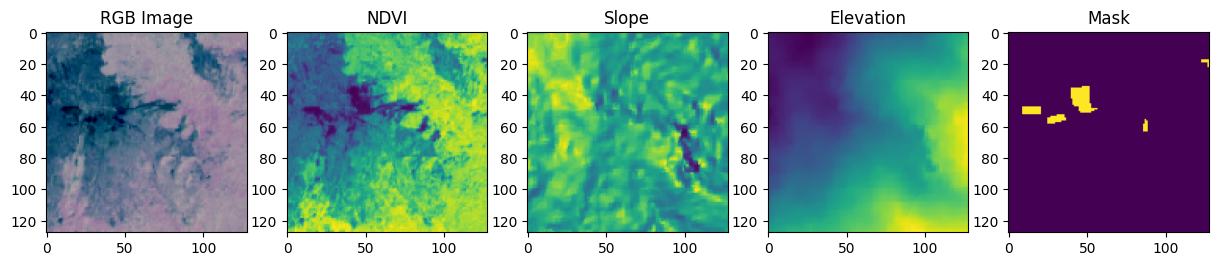

In [20]:
img = 28
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 10))


ax1.set_title("RGB Image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")

ax1.imshow(train_xx[img, :, :, 0:3])
ax2.imshow(train_xx[img, :, :, 3])
ax3.imshow(train_xx[img, :, :, 4])
ax4.imshow(train_xx[img, :, :, 5])
ax5.imshow(train_yy[img, :, :, 0])

## Validation Split

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_xx, train_yy, test_size=0.2, shuffle = True)

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

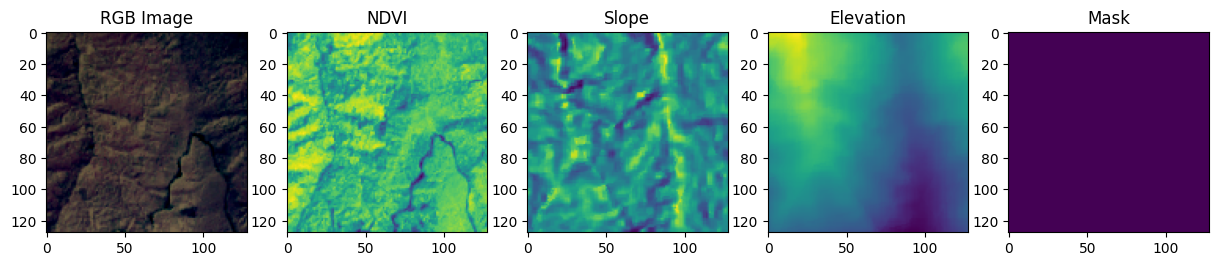

In [22]:
img = 20
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 10))


ax1.set_title("RGB Image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")

ax1.imshow(X_train[img, :, :, 0:3])
ax2.imshow(X_train[img, :, :, 3])
ax3.imshow(X_train[img, :, :, 4])
ax4.imshow(X_train[img, :, :, 5])
ax5.imshow(y_train[img, :, :, 0])

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40, 128, 128, 6), (10, 128, 128, 6), (40, 128, 128, 1), (10, 128, 128, 1))

In [24]:
# Image analysis requires a lot of memory, so release the unnecessary variables

del train_xx
del train_yy
del all_train
del all_mask

In [25]:
!pip install segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00


In [26]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
weights = [0.166]

Segmentation Models: using `tf.keras` framework.


In [27]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

## Using U-Net Model

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [29]:
def multi_unet_model(n_classes, image_height, image_width, image_channels):
  input = Input((image_height, image_width, image_channels))

  source_input = input

  c1 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(c1)
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  c3 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(c3)
  p3 = MaxPooling2D((2, 2))(c3)

  c4 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(c4)
  p4 = MaxPooling2D((2, 2))(c4)

  c5 = Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(c5)

  u6 = Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = "same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(c6)

  u7 = Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = "same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(c7)

  u8 = Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = "same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(c8)

  u9 = Conv2DTranspose(16, (2, 2), strides = (2, 2), padding = "same")(c8)
  u9 = concatenate([u9, c1], axis = 3)
  c9 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(c9)

  output = Conv2D(n_classes, (1, 1), activation = "sigmoid")(c9)

  model = Model(inputs = [input], outputs = [output])
  return model



def get_deep_learning_model():
  return multi_unet_model(n_classes = 1,
                          image_height = 128,
                          image_width = 128,
                          image_channels = 6)




unet_model = get_deep_learning_model()

In [30]:
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 6)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            880 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 128)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,941,537 (7.41 MB)

 Trainable params: 1,941,537 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpointer = tf.keras.callbacks.ModelCheckpoint("best_model.h5", monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'max')


callbacks = [checkpointer]

In [32]:
history_a = unet_model.fit(X_train, y_train, epochs = 20, batch_size = 4, verbose = 1, validation_data = (X_test, y_test), callbacks = callbacks)
unet_model.save("unet_model_landslide_save.h5")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(4, 128, 128, 6))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8129 - loss: 0.4458

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 6))
  warnings.warn(msg)



Epoch 1: val_loss improved from -inf to 0.14998, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8216 - loss: 0.4320 - val_accuracy: 0.9721 - val_loss: 0.1500
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.9818 - loss: 0.1308
Epoch 2: val_loss did not improve from 0.14998
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 887ms/step - accuracy: 0.9820 - loss: 0.1290 - val_accuracy: 0.9721 - val_loss: 0.1251
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.9809 - loss: 0.0901
Epoch 3: val_loss did not improve from 0.14998
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 893ms/step - accuracy: 0.9812 - loss: 0.0892 - val_accuracy: 0.9721 - val_loss: 0.1081
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.9801 - loss: 0.0847
Epoch 4: val_loss did not improve from 0.14998
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 687ms/step - accuracy: 0.9804 - loss: 0.0831 - val_accuracy: 0.9721 - val_loss: 0.0890
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.9831 - loss: 0.0608
Epoch 5: val_loss did not improve from 0.14998
1

In [33]:
loss, accuracy = unet_model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9773 - loss: 0.0565


In [34]:
history_a.history

{'accuracy': [0.9082260131835938,
  0.9837356805801392,
  0.983837902545929,
  0.9838455319404602,
  0.9838485717773438,
  0.9838485717773438,
  0.9838516116142273,
  0.9838485717773438,
  0.9838546514511108,
  0.983935534954071,
  0.9843719601631165,
  0.9854354858398438,
  0.986175537109375,
  0.987139880657196,
  0.9872711300849915,
  0.9876556396484375,
  0.9875869750976562,
  0.987408459186554,
  0.9879897832870483,
  0.9881668090820312],
 'loss': [0.29424113035202026,
  0.11107908189296722,
  0.0799466222524643,
  0.06719569116830826,
  0.055264197289943695,
  0.04925767332315445,
  0.04664003103971481,
  0.046859655529260635,
  0.04413337633013725,
  0.04164835810661316,
  0.04037037119269371,
  0.03967040032148361,
  0.03927156329154968,
  0.03833296149969101,
  0.038048140704631805,
  0.03702948987483978,
  0.03738725185394287,
  0.03795204684138298,
  0.03570142388343811,
  0.03497849404811859],
 'val_accuracy': [0.9721130132675171,
  0.9721130132675171,
  0.9721130132675171,

In [35]:
## Visualization

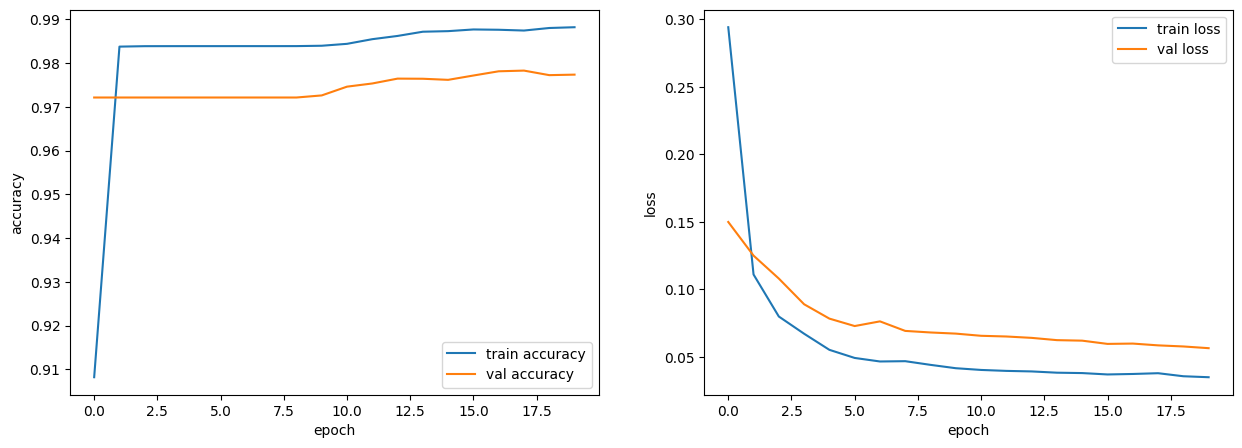

In [49]:
fig, (ax1, ax2) =  plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history_a.history['accuracy'])
ax1.plot(history_a.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train accuracy', 'val accuracy'])

ax2.plot(history_a.history['loss'])
ax2.plot(history_a.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.legend(['train loss', 'val loss'])

plt.show()

In [37]:
threshold =  0.5
pred_img = unet_model.predict(X_test)
pred_img = (pred_img > threshold).astype(np.uint8)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(10, 128, 128, 6))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


Text(0.5, 1.0, 'Original  Image')

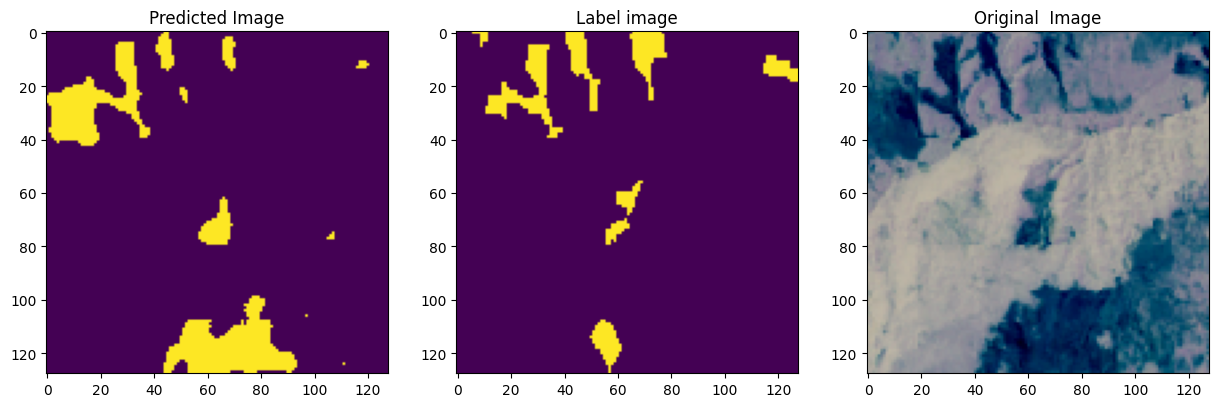

In [52]:
img = 7
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title('Predicted Image')
ax2.imshow(y_test[img, :, :, 0])
ax2.set_title('Label image')
ax3.imshow(X_test[img, :, :, 0:3])
ax3.set_title('Original  Image')

In [39]:
## Validation data

In [54]:
validation_path = r"ValidData/*.h5"

valid_xx = np.zeros((30, 128, 128, 6))
valid_yy = np.zeros((30, 128, 128, 1))

all_valid = sorted(glob.glob(train_path))

In [55]:
for i, img in enumerate(all_valid[0:30]):
  print(i, img)
  with h5py.File(img) as hdf:
    ls = list(hdf.keys())
    data = np.array(hdf.get('img'))

    data[np.isnan(data)] = 0.000001

    mid_rgb = data[:, :, 1:4].max()/2.0
    mid_slope = data[:, :, 12].max()/2.0
    mid_elevation = data[:, :, 13].max()/2.0

    data_red = data[:, :, 3]
    data_nir = data[:, :, 7]
    data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red))

    valid_xx[i, :, :, 0] = 1-data[:, :, 3]/mid_rgb # red
    valid_xx[i, :, :, 1] = 1-data[:, :, 2]/mid_rgb # green
    valid_xx[i, :, :, 2] = 1-data[:, :, 1]/mid_rgb # blue
    valid_xx[i, :, :, 3] = data_ndvi
    valid_xx[i, :, :, 4] = 1-data[:, :, 12]/mid_slope  # slope
    valid_xx[i, :, :, 5] = 1-data[:, :, 13]/mid_elevation # elevation


0 TrainData/img/image_1.h5
1 TrainData/img/image_10.h5
2 TrainData/img/image_100.h5
3 TrainData/img/image_11.h5
4 TrainData/img/image_12.h5
5 TrainData/img/image_13.h5
6 TrainData/img/image_14.h5
7 TrainData/img/image_15.h5
8 TrainData/img/image_16.h5
9 TrainData/img/image_17.h5
10 TrainData/img/image_18.h5
11 TrainData/img/image_19.h5
12 TrainData/img/image_2.h5
13 TrainData/img/image_20.h5
14 TrainData/img/image_21.h5
15 TrainData/img/image_22.h5
16 TrainData/img/image_23.h5
17 TrainData/img/image_24.h5
18 TrainData/img/image_25.h5
19 TrainData/img/image_26.h5
20 TrainData/img/image_27.h5
21 TrainData/img/image_28.h5
22 TrainData/img/image_29.h5
23 TrainData/img/image_3.h5
24 TrainData/img/image_30.h5
25 TrainData/img/image_31.h5
26 TrainData/img/image_32.h5
27 TrainData/img/image_33.h5
28 TrainData/img/image_34.h5
29 TrainData/img/image_35.h5


In [56]:
## Prediction for validation data

In [57]:
threshold =  0.5
pred_val_img = unet_model.predict(valid_xx)
pred_val_img = (pred_img > threshold).astype(np.uint8)
pred_val_img.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(10, 128, 128, 1)

In [58]:
# Visualization of validation image

Text(0.5, 1.0, 'Original  Image')

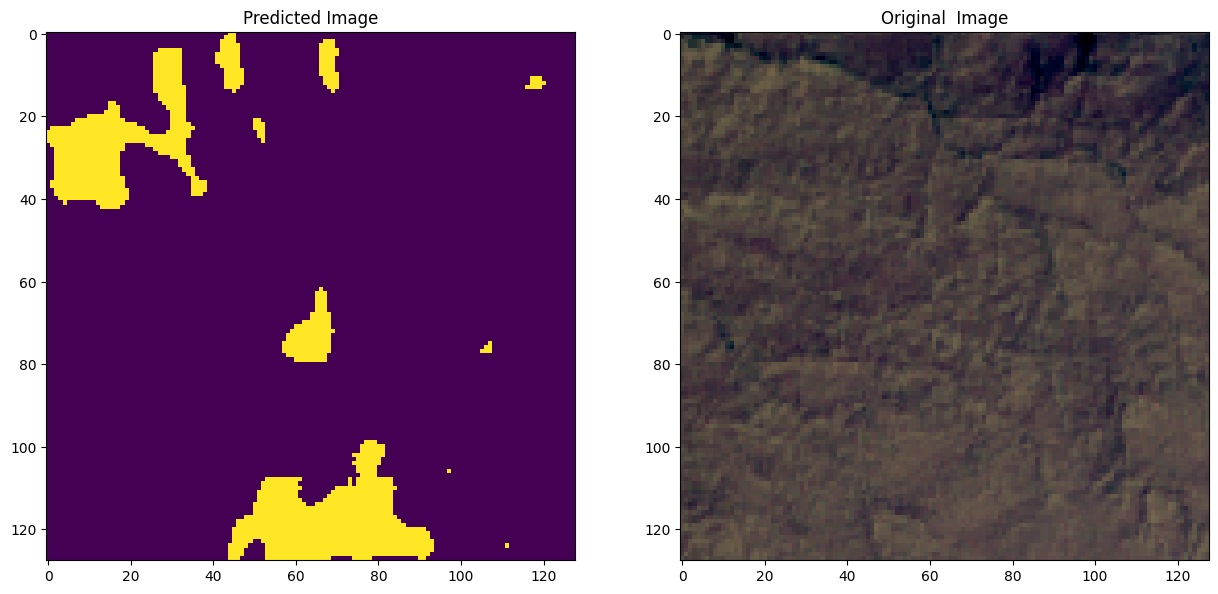

In [62]:
img = 7
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15, 10))
ax1.imshow(pred_val_img[img, :, :, 0])
ax1.set_title('Predicted Image')
ax3.imshow(valid_xx[img, :, :, 0:3])
ax3.set_title('Original  Image')

In [46]:
## Saving the model

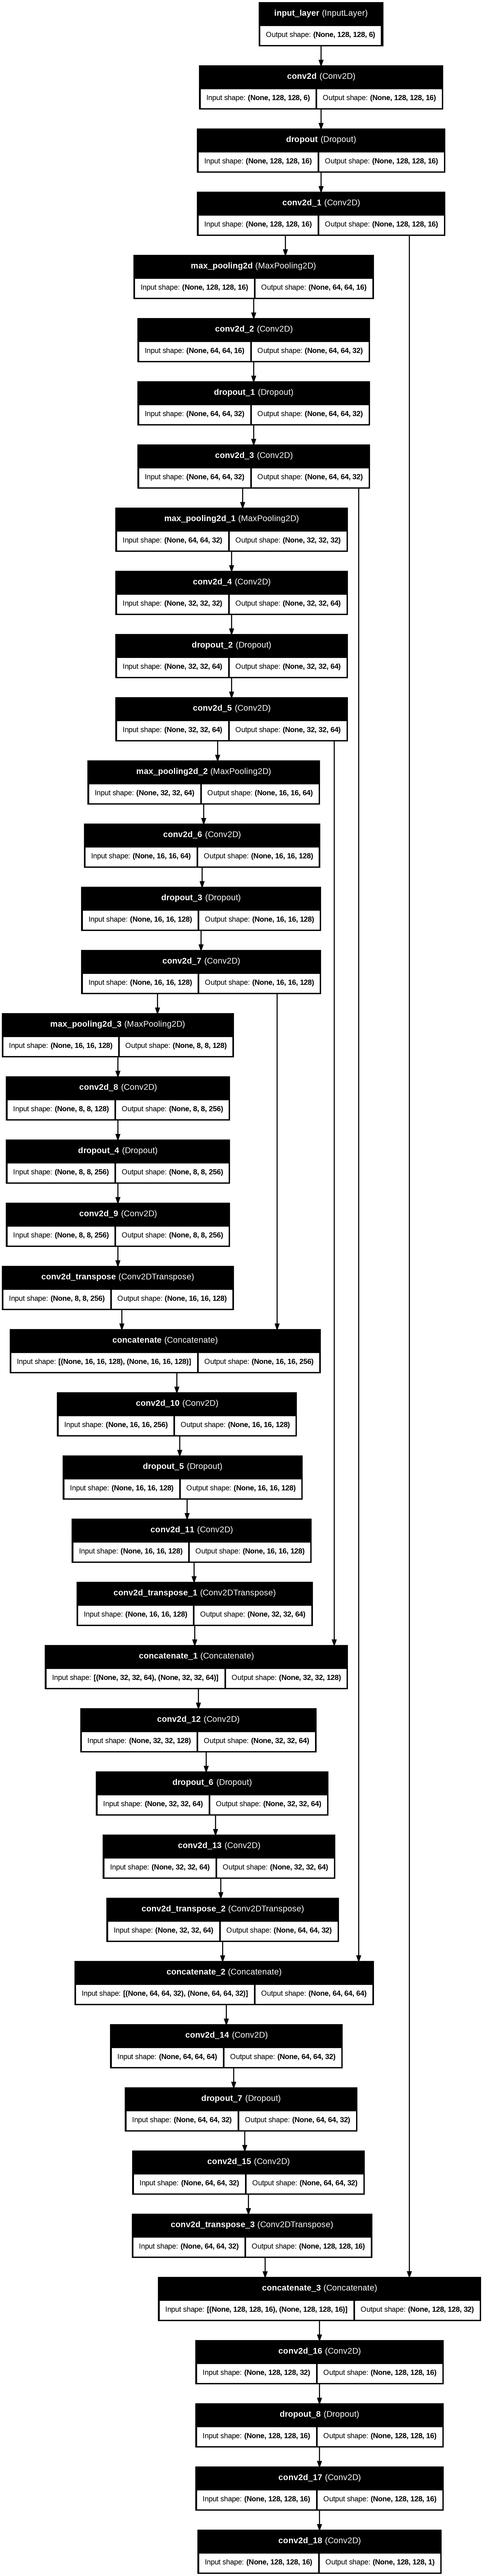

In [47]:
from tensorflow.keras.utils import plot_model
plot_model(unet_model, to_file = 'landslide_detection_model_plot.png', show_shapes = True, show_layer_names = True)

In [48]:
unet_model.save("Landslide_segmentation_and_prediction_model.keras")